# Assignment I Natural Language Processing Course
# Neural-based Language Model: Indonesian Poem Generation
by Ryan Abdurohman (1301191171)

Catatan: vocab_sz nya ganti jadi len(dls.vocab) (?)

In [ ]:
# !pip install -Uqq fastbook fastai

In [1]:
from fastbook import *
from fastai.text.all import *
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://raw.githubusercontent.com/Wikidepia/indonesian_datasets/master/crawl/twitter-puisi/data/pelangipuisi.jsonl

--2022-05-23 01:12:20--  https://raw.githubusercontent.com/Wikidepia/indonesian_datasets/master/crawl/twitter-puisi/data/pelangipuisi.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11389849 (11M) [text/plain]
Saving to: ‘pelangipuisi.jsonl’

pelangipuisi.jsonl  100%[===================>]  10.86M  19.4MB/s    in 0.6s    

2022-05-23 01:12:24 (19.4 MB/s) - ‘pelangipuisi.jsonl’ saved [11389849/11389849]



In [12]:
!gdown --id 140MXdsU3qsFAGp-Y8KroQPtNSmh1esno

/opt/conda/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=140MXdsU3qsFAGp-Y8KroQPtNSmh1esno
To: /home/10epoch.pth
100%|████████████████████████████████████████| 177M/177M [00:06<00:00, 28.7MB/s]


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Data Preparation

In [5]:
df = pd.read_json(path_or_buf="pelangipuisi.jsonl", lines=True) # read data, convert it to dataframe
df = df.replace(r'\n',' ', regex=True) # replace new line into single space
df = df.applymap(lambda s:s.lower() if type(s) == str else s) # convert all character into lower case
df.head()

,text
0,"hanya karena sapa itu. kau tikam rasamu. sisakan, bulir-bulir sedu."
1,sedang di antrian panjang pada sebuah penantian entah kapan rindu memanggil sebab ada temu yang masih tertinggal
2,"jika kau bukan tempat awal untuk berlabuh, maka kau yang terakhir di mana aku terjatuh kemudian karam"
3,"setiap waktu, aku masih mendengar getar dawai aksaramu, hingga aku terlelap dibuai bayangmu, dan setiap waktuku masih berdo'a yang sama, membelai gelombang tak lupa pula"
4,sebait rindu yang kau bacakan masih terdengar jelas dalam keresahan selembar rindu yang kau tulis di catatan masih terbaca nyata dalam kegilaan sekumpulan rindu yang kau jadikan buku bacaan masih kucetak menjadi kenangan paling edan


In [6]:
df_test = df[85000:]

In [7]:
batch_size = 64
max_seq_len = 72
seed = 42
val_sz = 0.1

In [8]:
set_seed(42)
dls = TextDataLoaders.from_df(df[:85000], valid_pct=val_sz, seed=seed, is_lm=True, seq_len=max_seq_len, backwards=False, bs=batch_size)

In [9]:
dls_test = TextDataLoaders.from_df(
    df_test, valid_pct=0, seed=seed,
    is_lm=True, seq_len=max_seq_len,
    backwards=False, bs=batch_size, text_vocab=dls.vocab
)

In [10]:
dls.cuda()
dls_test.cuda()

In [13]:
dls.show_batch(max_n=3)

,text,text_
0,"xxbos akan ada kabar dijatuhkan burung , bukan air hujan , tapi mataku basah karenanya . xxbos xxunk , awalnya aku ragu tentang rasa yang tak pernah hilang , ternyata itu benar adanya . kamu pernah pergi , sekarang datang lagi . xxbos ketika kau tanya mengapa aku diam mengapa aku ingin sendiri mengapa aku akan menjawabnya mengapa kau selalu ada ; dalam setiap yang aku lihat … xxbos saat purnama begitu","akan ada kabar dijatuhkan burung , bukan air hujan , tapi mataku basah karenanya . xxbos xxunk , awalnya aku ragu tentang rasa yang tak pernah hilang , ternyata itu benar adanya . kamu pernah pergi , sekarang datang lagi . xxbos ketika kau tanya mengapa aku diam mengapa aku ingin sendiri mengapa aku akan menjawabnya mengapa kau selalu ada ; dalam setiap yang aku lihat … xxbos saat purnama begitu pijar"
1,"namun lembut nian mengusap nurani menyeka jiwa setenang maut xxbos aku bisa menukar sepi dengan secangkir kopi … tapi bagaimana dengan rindu ini ? xxbos hei xxunk kau ? aku di sini menyanyikan lagu sedu sedan untukmu , ungkapan betapa gersang dunia yang tak kau xxunk cinta … xxbos detik - detik waktu berdenting . xxunk bunga melayang jatuh membumi . pada tanah , semua makhluk pulang , berserah . kembali ;","lembut nian mengusap nurani menyeka jiwa setenang maut xxbos aku bisa menukar sepi dengan secangkir kopi … tapi bagaimana dengan rindu ini ? xxbos hei xxunk kau ? aku di sini menyanyikan lagu sedu sedan untukmu , ungkapan betapa gersang dunia yang tak kau xxunk cinta … xxbos detik - detik waktu berdenting . xxunk bunga melayang jatuh membumi . pada tanah , semua makhluk pulang , berserah . kembali ; dipeluk"
2,"adalah ketidakmungkinan yang selalu aku perjuangkan sendirian . xxbos aku akan diam , tetapi jemariku akan terus bicara , berteriak tentang keadilan yang kau bungkam . xxbos pada senyum yang sore itu merekah ; sungguh aku tak sengaja jatuh cinta . xxbos kisah lama kembali terkenang lagu lama kembali terngiang nyala lilin mulai surut padam xxbos semesta memberi isyarat , aku kepingan tulang rusukmu yang hilang . xxbos lara itu , membias","ketidakmungkinan yang selalu aku perjuangkan sendirian . xxbos aku akan diam , tetapi jemariku akan terus bicara , berteriak tentang keadilan yang kau bungkam . xxbos pada senyum yang sore itu merekah ; sungguh aku tak sengaja jatuh cinta . xxbos kisah lama kembali terkenang lagu lama kembali terngiang nyala lilin mulai surut padam xxbos semesta memberi isyarat , aku kepingan tulang rusukmu yang hilang . xxbos lara itu , membias tak"


## Single Layer RNN

In [77]:
class RNNModel(Module):
  def __init__(self, vocab_sz=len(dls.vocab), n_hidden=64, n_layers=1):
    self.input_hidden = nn.Embedding(vocab_sz, n_hidden)
    self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
    self.hidden_output = nn.Linear(n_hidden, vocab_sz)
    self.hidden = torch.zeros(n_layers, batch_size, n_hidden,device="cuda:0")

  def forward(self, x):
    res, h = self.rnn(self.input_hidden(x), self.hidden)
    self.hidden = h.detach()
    return self.hidden_output(res)
  
  def reset(self): self.hidden.zero_()

In [78]:
set_seed(42)
learn = Learner(
    dls, RNNModel(),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, Perplexity()],
    )

In [79]:
learn.model.cuda()

RNNModel(
  (input_hidden): Embedding(17440, 64)
  (rnn): RNN(64, 64, batch_first=True)
  (hidden_output): Linear(in_features=64, out_features=17440, bias=True)
)

SuggestedLRs(valley=0.0010000000474974513)

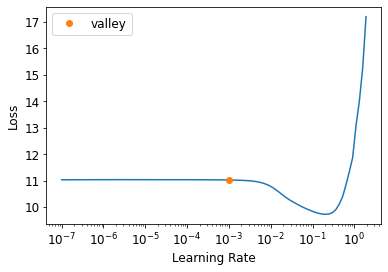

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,8.482556,7.808226,0.054036,2460.761475,01:01
1,6.545012,6.468305,0.094347,644.390320,01:01
2,6.338085,6.219093,0.115506,502.247650,01:01
3,6.144879,6.080202,0.131076,437.117523,01:01
4,6.006679,5.965233,0.136773,389.643738,01:01
5,5.925325,5.927341,0.141005,375.155457,01:02
6,5.873891,5.854859,0.143446,348.925659,01:02
7,5.823319,5.839038,0.141222,343.448914,01:03
8,5.785125,5.797320,0.144857,329.415649,01:02
9,5.753439,5.767610,0.145996,319.772430,01:02


Better model found at epoch 0 with valid_loss value: 7.808226108551025.


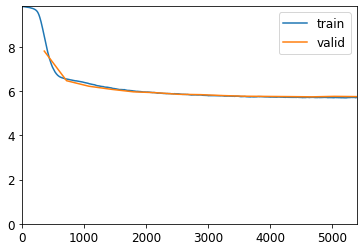

Better model found at epoch 1 with valid_loss value: 6.468304634094238.
Better model found at epoch 2 with valid_loss value: 6.219093322753906.
Better model found at epoch 3 with valid_loss value: 6.080202102661133.
Better model found at epoch 4 with valid_loss value: 5.965232849121094.
Better model found at epoch 5 with valid_loss value: 5.927340507507324.
Better model found at epoch 6 with valid_loss value: 5.854858875274658.
Better model found at epoch 7 with valid_loss value: 5.839038372039795.
Better model found at epoch 8 with valid_loss value: 5.797320365905762.
Better model found at epoch 9 with valid_loss value: 5.767609596252441.
Better model found at epoch 10 with valid_loss value: 5.758821964263916.
Better model found at epoch 11 with valid_loss value: 5.750332355499268.
Better model found at epoch 12 with valid_loss value: 5.740071773529053.


In [80]:
learn.fit_one_cycle(15, 0.001, wd=0.1, cbs=[
         EarlyStoppingCallback(monitor='valid_loss', patience=3),
         ShowGraphCallback(),
         SaveModelCallback(fname='single_layer_rnn', at_end=True)
         ])

In [81]:
res = learn.validate()
print(f"Data Validasi: Akurasi {res[1]}, Perplexity {res[2]}")
# change to test data
learn.dls.valid = dls_test.train
res = learn.validate()
print(f"Data Uji: Akurasi {res[1]}, Perplexity {res[2]}")

Data Validasi: Akurasi 0.1481119692325592, Perplexity 312.5715637207031


Data Uji: Akurasi 0.1480034738779068, Perplexity 318.2174377441406


## Single Layer LSTM

In [29]:
class LSTMModel(Module):
    def __init__(self, vocab_sz=len(dls.vocab), n_hidden=64, n_layers=1):
        self.input_hidden = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.hidden_output = nn.Linear(n_hidden, vocab_sz)
        self.hidden = [torch.zeros(n_layers, batch_size, n_hidden,device="cuda:0") for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.input_hidden(x), self.hidden)
        self.hidden = [h_.detach() for h_ in h]
        return self.hidden_output(res)
    
    def reset(self): 
        for h in self.hidden: h.zero_()

In [30]:
set_seed(42)
learn_lstm = Learner(dls, LSTMModel(), loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Perplexity()])

In [31]:
learn_lstm.model.cuda()

LSTMModel(
  (input_hidden): Embedding(17440, 64)
  (rnn): LSTM(64, 64, batch_first=True)
  (hidden_output): Linear(in_features=64, out_features=17440, bias=True)
)

SuggestedLRs(valley=0.0006918309954926372)

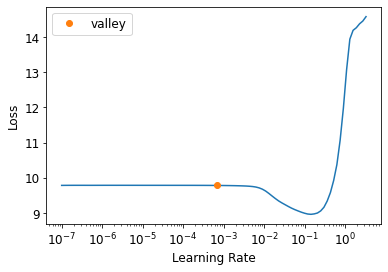

In [32]:
learn_lstm.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,8.999689,8.382392,0.038628,4369.447754,01:01
1,6.610837,6.499115,0.098307,664.553223,01:01
2,6.475093,6.375057,0.114855,587.019043,01:01
3,6.302496,6.232049,0.126411,508.796936,01:02
4,6.182224,6.142237,0.129015,465.092682,01:01
5,6.081946,6.037089,0.137153,418.672638,01:01
6,6.022507,5.981839,0.138943,396.168335,01:01
7,5.971418,5.945356,0.138835,381.975464,01:01
8,5.937289,5.910521,0.139811,368.898315,01:01
9,5.909872,5.909383,0.139486,368.478668,01:02


Better model found at epoch 0 with valid_loss value: 8.382391929626465.


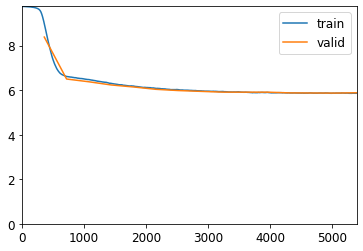

Better model found at epoch 1 with valid_loss value: 6.499114990234375.
Better model found at epoch 2 with valid_loss value: 6.375057220458984.
Better model found at epoch 3 with valid_loss value: 6.232048988342285.
Better model found at epoch 4 with valid_loss value: 6.142236709594727.
Better model found at epoch 5 with valid_loss value: 6.0370893478393555.
Better model found at epoch 6 with valid_loss value: 5.981839179992676.
Better model found at epoch 7 with valid_loss value: 5.945356369018555.
Better model found at epoch 8 with valid_loss value: 5.910521030426025.
Better model found at epoch 9 with valid_loss value: 5.9093828201293945.
Better model found at epoch 10 with valid_loss value: 5.908431529998779.
Better model found at epoch 11 with valid_loss value: 5.876415252685547.
Better model found at epoch 12 with valid_loss value: 5.871376037597656.
Better model found at epoch 13 with valid_loss value: 5.8676581382751465.


In [34]:
learn_lstm.fit_one_cycle(15, 0.00069, wd=0.1, cbs=[
         EarlyStoppingCallback(monitor='valid_loss', patience=3),
         ShowGraphCallback(),
         SaveModelCallback(fname='single_layer_lstm', at_end=True)
         ])

In [35]:
res = learn_lstm.validate()
print(f"Data Validasi: Akurasi {res[1]}, Perplexity {res[2]}")
# change to test data
learn_lstm.dls.valid = dls_test.train
res = learn_lstm.validate()
print(f"Data Uji: Akurasi {res[1]}, Perplexity {res[2]}")

Data Validasi: Akurasi 0.1437174528837204, Perplexity 364.90313720703125


Data Uji: Akurasi 0.1438802182674408, Perplexity 366.26025390625


## Single Layer AWD-LSTM

In [37]:
class AWDLSTMModel(Module):
    def __init__(self, vocab_sz=len(dls.vocab), n_hidden=64, n_layers=1, p=0.5):
        self.input_hidden = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.hidden_output = nn.Linear(n_hidden, vocab_sz)
        self.hidden_output.weight = self.input_hidden.weight
        self.hidden = [torch.zeros(n_layers, batch_size, n_hidden,device="cuda:0") for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.input_hidden(x), self.hidden)
        out = self.drop(raw)
        self.hidden = [h_.detach() for h_ in h]
        return self.hidden_output(out),raw,out
    
    def reset(self): 
        for h in self.hidden: h.zero_()

In [41]:
set_seed(42)
learn_awd = TextLearner(dls, AWDLSTMModel(), loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Perplexity()])

In [42]:
learn_awd.model.cuda()

AWDLSTMModel(
  (input_hidden): Embedding(17440, 64)
  (rnn): LSTM(64, 64, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
  (hidden_output): Linear(in_features=64, out_features=17440, bias=True)
)

SuggestedLRs(valley=0.004365158267319202)

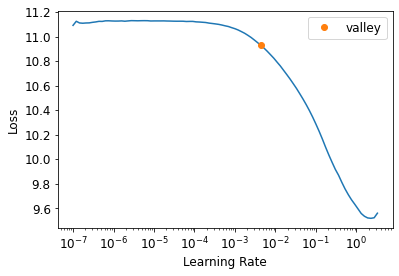

In [43]:
learn_awd.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,9.075544,8.493856,0.092611,4884.666992,01:02
1,7.111200,6.532809,0.119032,687.326050,01:02
2,6.541183,6.233478,0.132270,509.524567,01:02
3,6.277019,6.050770,0.140516,424.439850,01:02
4,6.119103,5.914201,0.150933,370.258270,01:02
5,6.009107,5.805638,0.156033,332.167145,01:02
6,5.921597,5.749159,0.155870,313.926636,01:02
7,5.862809,5.726295,0.159831,306.830505,01:02
8,5.827181,5.679955,0.159125,292.936096,01:02
9,5.784267,5.629260,0.162977,278.455872,01:02


Better model found at epoch 0 with valid_loss value: 8.493856430053711.


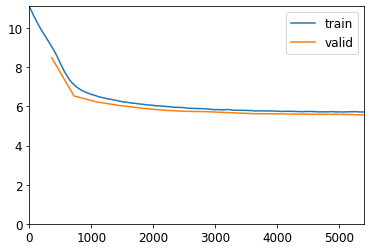

Better model found at epoch 1 with valid_loss value: 6.532808780670166.
Better model found at epoch 2 with valid_loss value: 6.23347806930542.
Better model found at epoch 3 with valid_loss value: 6.050770282745361.
Better model found at epoch 4 with valid_loss value: 5.914200782775879.
Better model found at epoch 5 with valid_loss value: 5.805638313293457.
Better model found at epoch 6 with valid_loss value: 5.749159336090088.
Better model found at epoch 7 with valid_loss value: 5.726295471191406.
Better model found at epoch 8 with valid_loss value: 5.679954528808594.
Better model found at epoch 9 with valid_loss value: 5.6292595863342285.
Better model found at epoch 10 with valid_loss value: 5.619962692260742.
Better model found at epoch 11 with valid_loss value: 5.606080532073975.
Better model found at epoch 12 with valid_loss value: 5.596090316772461.
Better model found at epoch 13 with valid_loss value: 5.592938423156738.
Better model found at epoch 14 with valid_loss value: 5.5670

In [44]:
learn_awd.fit_one_cycle(15, 0.0043, wd=0.1, cbs=[
         EarlyStoppingCallback(monitor='valid_loss', patience=3),
         ShowGraphCallback(),
         SaveModelCallback(fname='single_layer_awd', at_end=True)
         ])

In [45]:
res = learn_awd.validate()
print(f"Data Validasi: Akurasi {res[1]}, Perplexity {res[2]}")
# change to test data
learn_awd.dls.valid = dls_test.train
res = learn_awd.validate()
print(f"Data Uji: Akurasi {res[1]}, Perplexity {res[2]}")

Data Validasi: Akurasi 0.167751744389534, Perplexity 263.8412170410156


Data Uji: Akurasi 0.1672634482383728, Perplexity 261.6553039550781


## Default AWD-LSTM

In [46]:
set_seed(42)
learn_awd_def = language_model_learner(dls, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()], pretrained=False)

In [47]:
learn_awd_def.cuda()

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(17440, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(17440, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=17440, bias=True)
    (output_dp): RNNDropout()
  )
)

SuggestedLRs(valley=0.00019054606673307717)

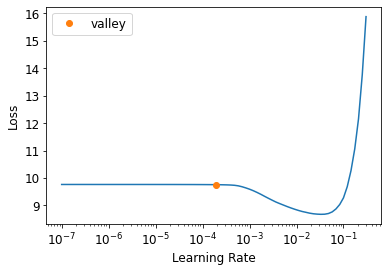

In [48]:
learn_awd_def.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,7.275515,6.927076,0.071940,1019.508911,01:39
1,6.652841,6.604255,0.070909,738.229492,01:39
2,6.648167,6.585809,0.072049,724.736938,01:39
3,6.642791,6.578172,0.071452,719.223511,01:40
4,6.536082,6.517642,0.092556,676.979858,01:39
5,6.398326,6.329387,0.118273,560.812561,01:40
6,6.289979,6.223843,0.125977,504.638641,01:39
7,6.231661,6.182824,0.132161,484.357697,01:39
8,6.174180,6.169163,0.131402,477.785919,01:39
9,6.126426,6.094153,0.131782,443.258423,01:40


Better model found at epoch 0 with valid_loss value: 6.92707633972168.


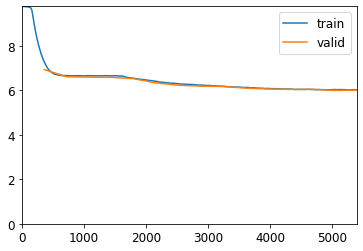

Better model found at epoch 1 with valid_loss value: 6.604254722595215.
Better model found at epoch 2 with valid_loss value: 6.585808753967285.
Better model found at epoch 3 with valid_loss value: 6.578172206878662.
Better model found at epoch 4 with valid_loss value: 6.517641544342041.
Better model found at epoch 5 with valid_loss value: 6.3293867111206055.
Better model found at epoch 6 with valid_loss value: 6.223842620849609.
Better model found at epoch 7 with valid_loss value: 6.182823657989502.
Better model found at epoch 8 with valid_loss value: 6.169162750244141.
Better model found at epoch 9 with valid_loss value: 6.094152927398682.
Better model found at epoch 10 with valid_loss value: 6.055995941162109.
Better model found at epoch 11 with valid_loss value: 6.036830425262451.
Better model found at epoch 13 with valid_loss value: 5.990571975708008.


In [49]:
learn_awd_def.fit_one_cycle(15, 0.00019, wd=0.1, cbs=[
         EarlyStoppingCallback(monitor='valid_loss', patience=3),
         ShowGraphCallback(),
         SaveModelCallback(fname='default_awd', at_end=True)
         ])

In [50]:
res = learn_awd_def.validate()
print(f"Data Validasi: Akurasi {res[1]}, Perplexity {res[2]}")
# change to test data
learn_awd_def.dls.valid = dls_test.train
res = learn_awd_def.validate()
print(f"Data Uji: Akurasi {res[1]}, Perplexity {res[2]}")

Data Validasi: Akurasi 0.1355794370174408, Perplexity 402.08502197265625


Data Uji: Akurasi 0.1395941823720932, Perplexity 410.86151123046875


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.021278,5.980530,0.140679,395.650116,01:38
1,5.992171,5.953842,0.144206,385.230438,01:38
2,5.943467,5.935650,0.144640,378.285919,01:39
3,5.881667,5.862874,0.150499,351.733429,01:39
4,5.820036,5.822718,0.150716,337.889252,01:40
5,5.787885,5.784593,0.154785,325.249664,01:39
6,5.752047,5.757571,0.154460,316.578339,01:39
7,5.716460,5.736421,0.157010,309.952972,01:40
8,5.683439,5.688843,0.161024,295.551392,01:39
9,5.687036,5.692395,0.161404,296.603210,01:39


Better model found at epoch 0 with valid_loss value: 5.980530261993408.


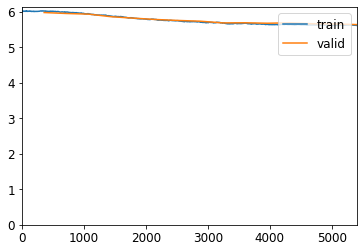

Better model found at epoch 1 with valid_loss value: 5.953841686248779.
Better model found at epoch 2 with valid_loss value: 5.93565034866333.
Better model found at epoch 3 with valid_loss value: 5.862873554229736.
Better model found at epoch 4 with valid_loss value: 5.822718143463135.
Better model found at epoch 5 with valid_loss value: 5.784593105316162.
Better model found at epoch 6 with valid_loss value: 5.757570743560791.
Better model found at epoch 7 with valid_loss value: 5.736420631408691.
Better model found at epoch 8 with valid_loss value: 5.6888427734375.
Better model found at epoch 10 with valid_loss value: 5.679152488708496.
Better model found at epoch 12 with valid_loss value: 5.664518356323242.
Better model found at epoch 13 with valid_loss value: 5.658283710479736.
Better model found at epoch 14 with valid_loss value: 5.641295909881592.


In [73]:
set_seed(42)
learn_awd_def_more = language_model_learner(
    dls, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()], pretrained=False
)
learn_awd_def_more.load("default_awd")
learn_awd_def_more.cuda()
learn_awd_def_more.fit_one_cycle(15, 0.00019, wd=0.1, cbs=[
         EarlyStoppingCallback(monitor='valid_loss', patience=3),
         ShowGraphCallback(),
         SaveModelCallback(fname='default_awd_30', at_end=True)
         ])

In [74]:
res = learn_awd_def_more.validate()
print(f"Data Validasi: Akurasi {res[1]}, Perplexity {res[2]}")
# change to test data
learn_awd_def_more.dls.valid = dls_test.train
res = learn_awd_def_more.validate()
print(f"Data Uji: Akurasi {res[1]}, Perplexity {res[2]}")

Data Validasi: Akurasi 0.1624349057674408, Perplexity 290.74310302734375


Data Uji: Akurasi 0.1610243022441864, Perplexity 289.9018249511719


In [72]:
learn_awd_def.dls.valid == dls_test.train

True

## Fine-tuning Pre-trained AWD-LSTM

In [51]:
!gdown 1iw5v1XDy2qKjhj49nVS_xHHRlK11QJ2I

Downloading...
From: https://drive.google.com/uc?id=1iw5v1XDy2qKjhj49nVS_xHHRlK11QJ2I
To: /home/counter.pkl
100%|██████████████████████████████████████| 17.2M/17.2M [00:00<00:00, 33.1MB/s]


In [52]:
count_vocab = pickle.load(open("counter.pkl", "rb"))
voc = make_vocab(count_vocab)

In [53]:
set_seed(seed)
dls_pre = TextDataLoaders.from_df(
    df[:85000], valid_pct=0.1, seed=seed,
    is_lm=True, seq_len=max_seq_len,
    backwards=False, bs=batch_size, text_vocab=voc
)

In [54]:
dls_test_pre = TextDataLoaders.from_df(
    df_test, valid_pct=0, seed=seed,
    is_lm=True, seq_len=max_seq_len,
    backwards=False, bs=batch_size, text_vocab=voc
)

In [57]:
MODEL_PATH = "/home/10epoch"

In [58]:
set_seed(42)
learn_awd_pre = language_model_learner(dls_pre, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()], pretrained=False)
learn_awd_pre.load(MODEL_PATH)

SuggestedLRs(valley=0.0010000000474974513)

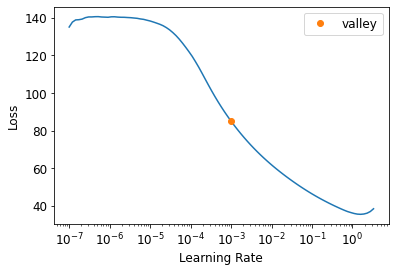

In [59]:
learn_awd_pre.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.316894,6.063812,0.164304,430.011414,02:12
1,5.577008,5.443118,0.177203,231.161850,02:13
2,5.212964,5.086733,0.202124,161.860184,02:13
3,4.982131,4.935570,0.207161,139.152466,02:12
4,4.843675,4.817307,0.219406,123.631645,02:13
5,4.718179,4.737479,0.223618,114.146103,02:12
6,4.602106,4.701371,0.224006,110.097984,02:13
7,4.517447,4.680462,0.227920,107.819916,02:13
8,4.388015,4.673097,0.227591,107.028664,02:13
9,4.273814,4.685056,0.227852,108.316307,02:13


Better model found at epoch 0 with valid_loss value: 6.063811779022217.


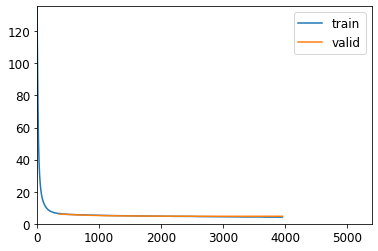

Better model found at epoch 1 with valid_loss value: 5.443118095397949.
Better model found at epoch 2 with valid_loss value: 5.086732864379883.
Better model found at epoch 3 with valid_loss value: 4.935570240020752.
Better model found at epoch 4 with valid_loss value: 4.8173065185546875.
Better model found at epoch 5 with valid_loss value: 4.737479209899902.
Better model found at epoch 6 with valid_loss value: 4.701370716094971.
Better model found at epoch 7 with valid_loss value: 4.68046236038208.
Better model found at epoch 8 with valid_loss value: 4.673096656799316.
No improvement since epoch 8: early stopping


In [60]:
learn_awd_pre.fit_one_cycle(15, 0.001, wd=0.1, cbs=[
         EarlyStoppingCallback(monitor='valid_loss', patience=3),
         ShowGraphCallback(),
         SaveModelCallback(fname='pre_awd', at_end=True)
         ])

In [61]:
res = learn_awd_pre.validate()
print(f"Data Validasi: Akurasi {res[1]}, Perplexity {res[2]}")
# change to test data
learn_awd_pre.dls.valid = dls_test_pre.train
res = learn_awd_pre.validate()
print(f"Data Uji: Akurasi {res[1]}, Perplexity {res[2]}")

Data Validasi: Akurasi 0.22371439635753632, Perplexity 112.36341094970703


Data Uji: Akurasi 0.2132703959941864, Perplexity 125.62030029296875


## Inference

In [62]:
def generate_poem(learner, TEXT="Aku", N_WORDS=40, N_SENTENCES=2):
  preds = [learner.predict(TEXT, n_words=N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]
  print("\n".join(preds))

### AWD LSTM Default 15 Epoch

In [65]:
generate_poem(learn_awd_def, TEXT="aku", N_WORDS=40, N_SENTENCES=5)

aku hampir lebih kau bisa ada dari dia yang tak akan masih tahu cuaca meski kau adalah tenggelam . tak keluarkan lagi kita . aku adalah ditinggalkan . aku sudah tak ingin aku masih pernah terbalas , di senja
aku meronce ada puisi yang seperti berbeda , aku telah bertemu . jika rindu ini mendung pada rindu dan tak pernah lagi takkan pernah mencintaimu , aku tak bisa membuat ganjil aku tak pernah hilang , tapi kau …
aku mentari yang telah mencari ada payung , tak bisa kembali - bersama yang dulu . saat malam yang bisa tidur , di ingin malam yang tak semesta , tidurlah , bersama saat sebuah dirimu . aku terasa adalah
aku air pagi tak kering itu aku yg bisa kenang , dik . meski biarkan hati , aku punya luka , tentang rindu yang tumbuh , tak harus bisa hal nan bersedih . senja hanya lagi aku akan kembali
aku ini tidak bisa kau jatuh . dari kau pergi , kau telah ada rindu - kau , mencintaimu . pada senja malam , kita yang ranting cinta di pagi ini . di hati pergi , dalam kita ,


In [66]:
generate_poem(learn_awd_def, TEXT="senja", N_WORDS=40, N_SENTENCES=5)

senja kikis - berlarian rasa yang membawa segala hanyut yang hanya kau semakin malu . aku bisa ulang , jadilah hatimu di antara bulan yang selalu dirimu , yang kamu , batas laut . pada rindu di malam yang
senja abu nangka memaksa itu " malam ini , rasanya tak pernah siap untuk sayatan , tapi kau sadar di setiap kenangan yang risau . mencintaimu ; senja hanya belum sepi ; tak tak lagi bahwa aku ingin kembali
senja bebaskan hari yang sedang kau untuk reda pada menerima setiap tentang rindu dan tak pernah jatuh . semakin aku tak pernah sempat merindu - kau tak pernah lagi saling kembali satu sunyi yang tak teduh hujan adalah kutemui
senja kesesatan saatnya saya baitnya yang mencintaimu yang dari kau berteduh . aku tidak ada aku semakin lagi . bening ini yang kan kusentuh . aku hanya kau . di selalu ada dengan jarak . pagiku ini ,
senja diberi kebenaran , aku ingin sengaja sajak ; mungkin begitu pikiran , aku tak nampak bagi . kau mengapa di sakit yang dan rembulan , namun seharusnya telah

### AWD LSTM Default 30 Epoch

In [75]:
generate_poem(learn_awd_def_more, TEXT="aku", N_WORDS=40, N_SENTENCES=5)

aku kita takkan bisa gagal , pun kau yang ada tak akan ada . bila tanpa bisu akan bisa ku lupa untuk bertemu , kamu akan mendengar kenangan bahkan tak sadar aku pun kemarau . seperti kekasih ; aku
aku lagi apa mataku masih di sini mimpi . tapi memang kita tetaplah ? tak tahu lagi aku selalu berdoa , sebab aku tak bisa . pada langit yang tak masih kau janjikan . akan rindu yang tak ada
aku tidak peduli kau tertawa , hanya semua yang selalu menjadi saudara yang tak lelah ditabuh . biar senja , aku telah menulis , rasanya , yang tersisa hanya sebuah cinta yang tak ingin kau datang . " aku
aku tak berujung lagi beritahu , ketika aku harus mengobati diri ? jika aku mengerti diri tempat ini tidak hanya untukku , saat - anak adalah kita yang tak lagi bisa bertemu . sepi , kubuka - kehilangan kembali
aku tak pernah cukupkah genggam cinta , aku akan butuh payah . entah , jarak yang selalu kembali pergi . ku harapkan senyummu , tak entah kau yang terluka . sebab saja daya aku tak mau mencintainy

In [76]:
generate_poem(learn_awd_def_more, TEXT="senja", N_WORDS=40, N_SENTENCES=5)

senja cangkirmu , kau ; mulut tak pernah rindu patah , dan harinya dan tak mampu menafsir rindu . di langit malam ; aku tak pernah bisa berdetak dalam genggaman . di malam yang mimpi . kau adalah hati
senja hinggap di sela jalan , barangkali tak ada kata yang sama , ia dan lusuh . waktu yang tak bisa ada dari ingatan , ketika kita tak tertahankan , aku ingin tinggal dalam kata - nya . dan
senja ingin tak akan pernah ingin … seperti angin dan hujan yang bersinar menarik hujan , dengan aku , tapi hanya hal - disakiti . dari aroma hujan yang tak lebih ke pelukan , yang tak tahu untuk menurunkan segala
senja , pualam yang mengusap jejak - anak harap yang tak ada lagi . kamu tak lagi lagi , sekali saja untuk . namun aku hanya dia yang tertuju dari satu - doa . tutup mata , aku di
senja erat ini , kita katakan , di lubuk menyayat hati dan puisi , kesepian ke dalam awan , dan aku saat kita lewat , pahit - mata . hari ini sudah datang , sampai ia tanam bersama di penghujung


### Fine-tuned Pretrained AWD LSTM

In [67]:
generate_poem(learn_awd_pre, TEXT="aku", N_WORDS=40, N_SENTENCES=5)

aku tak lagi pandai melawan kecoa , sedang aku malah mati dalam riuh kebencian . cinta yang kau ucap dari segala luka , akan terhapus oleh jarak dan waktu , yang terus bertahta dalam ruang tunggu . aku sangat
aku pergi dengan sejuta inisial yang kau dapat , lebih dulu dari apapun . aku tak pernah tau apa yang kau sebut cinta . bagiku , aku hanya orang bodoh yang mencintaimu dengan susah . hatimu yang gersang ,
aku hanya mencintaimu tanpa jeda . hanya saja , tak ada waktu yang bisa menemani . pagi ini aku rebah , teringat dengan sang mentari , tentang kenangan yang selalu di hati ini , tapi sayang hatiku . aku
aku hanya ingin menjadi payung , yang ingin kau pun tak bisa . tapi aku butuh waktu , untuk begitu bisa tak kering . kekasih , siang ini tak ada luka yang menyakitkan . selain hujan yang jatuh , sementara
aku nyanyi dalam barisan puisi . tanpa rasa cinta , diam tanpa suara . tanpa kau baca , ku berbicara . aku tak lagi berani bicara , karena aku sendiri hanyalah kamu yang mungkin 

In [68]:
generate_poem(learn_awd_pre, TEXT="senja", N_WORDS=40, N_SENTENCES=5)

senja adalah hujan yang selalu menyatukan kita dengan gerimis , dan begitu juga kita . meskipun tak ada yang mampu berkisah , ada yang indah di sana , kamu .. hati yang masih terluka , dan dia yang masih selalu
senja kali ini sungguh indah , dik , sayang . tak ada bintang yang lebih indah dari kita . tak ada yang bisa bersatu selain dunia tanpa warna . di punggung malam ; kenangan , tiada lagi rindu , yang
senja adalah cara tuhan tuk mencari kesedihan di dalamnya engkau , agar kau berkata , " cinta adalah cita dan dosa " . setelah kau pergi , aku yang telah dulu hidup , di saat rindu dan luka terus mengalir
senja datang lagi . saat aku mencari dia di sana . kau selalu ada tanpa kau tau . aku dan kamu bukan lagi milik kita . aku dan kamu saling menunggu tanpa diminta , saling memahami tanpa sengaja .
senja di bulan oktober , dan kamu masih saja menjadi sebuah nama yang sama , entah di mana , di titik terakhir , yang hanya bisa tersisa . aku pernah berdiri di tengah yang lain , untuk di 